# Classification - Supervised Classification

## 1. Classification as a prototype of machine learning technique

From this session and on, we will enter deeply into the realm of **machine learning (ML)**. We will see that a common pattern will be the necessity of training a model, the assessment of the model preformance, and finally the application of the model to the data to be studied.

One typical example of machine learning is the classification problem. This is the process of attributing a "**class**" (or equivalently, a "**label**") to an object of an arbitrary type (e.g. a string or an image) in order to catalogue it based on its **properties** (the actual information that we pass to the machine, e.g. the pixel intensities in the case of an image).

<table><tr>
    <td width=260>
        <img src="images/classification.png">
        <center>
            <br>
            Figure 1.1. Schematic classification in a 2D plot.
            <br>
            (From [here](https://towardsdatascience.com/supervised-vs-unsupervised-learning-14f68e32ea8d))
        </center>
    </td>
</tr></table>

### 1.2 Types of Classifications

Classification can come in 2 major flavors, based on the type of intervention by the user:

- **Unsupervised** | The classification is defined "unsupervised" when the user does not provide labels during the training process. In other words, the machine does not know a priori what a class is or what properties it should represent. On the contrary, it has to independently **learn the definition of each "class"** using the training data and only _then_ proceed to classify the actual data. For example we would like to distinguish two overlapping "clouds" in a scatter plot, and then classify future measurements based on which cloud they fall on. The user can assist the machine in splitting the training data into different classes by imposing the total number of classes, and by running the analysis using the properties which maximise the differences between objects. A classical application of unsupervised classification is represented by "clustering" analysis (see relevant session).

    _In practice, the machine learns to cluster objects with similar properties._


- **Supervised** | The classification is defined "supervised" when the user provides a label for each object in the training set. In this case, the idea is that we can train the model to associate the label with some given characteristics of the training data.

    _In practice, the machine learns to find similarities between objects with the same label._

In the reminder, we will only focus on the latter type.

### 1.3 Supervised classification - generative / discriminative classification

One approach to the classification problem involves the recognition of the function describing the density distribution of each class in the parameter space. This type of problem is called **generative classification** because it implies that we can find the distribution from which the data are generated (or better said, sampled).

**Discriminative classification** instead, includes any method which separates classes by "drawing" a boundary in the parameter space.

In Bayesian terms, generative classifiers model the joint probability (the likelihood **P(D|θ)**) while discriminative classifiers model the conditional probability (the posterior **P(θ|D)**) starting from the prior (**P(θ)**).

There exists a continously growing number of discriminative classifiers, therefore we will only concentrate on a representative selection to illustrate the generic approach. Namely, we will use:
- **$k$-nearest neighbor (KNN)**
- **Support Vector Machine (SVM)**


### 1.4. Model evaluation metrics

One more concept before introducing a real example: **how do we assess the performance of a classification?**

There exist a number of assessment metrics based on **confusion matrixes** like (but not limited to) the one in Figure 1.2.

<table><tr>
    <td width=600>
        <img src="images/confusion_matrix.png">
        <center>
            <br>
            Figure 1.2. **Confusion matrix** for classification.
            <br>
            (From [here](https://towardsdatascience.com/precision-vs-recall-386cf9f89488))
        </center>
    </td>
</tr></table>

In astrophysics we usually concentrate on **completeness** and **contamination** (see [this lik](http://connolly.github.io/introAstroML/blog/classification.html)):

$$completeness = \frac{True~Positives}{All~real~Positives} = \frac{True~Positives}{True~Positives + False~Negatives} = recall$$

$$contamination = \frac{False~Positives}{All~detected~Positives} = \frac{True~Positives}{True~Positives + False~Positives}$$

We will explore these metrics throught the next sessions.
<br>
Additionally, we will see how the assessment requires us to split the sample into a:
- **training** set
- **validation** set
- **test** set

## 2. The sample for our classification example: RR Lyrae variables

RR Lyrae are bright ($M_V \approx 0.6~{\rm mag}$), helium-burning, pulsating (see helium partial ionization zones) stars with period less than a day $\left(6{\rm h} \lesssim P \lesssim 18{\rm h}\right)$ and visual amplitudes in the range $\left(0.3, 1.2\right){\rm mag}$.

<img src="images/CMD_RR_Lyrae.svg" width=300>
<center>Figure 2.1. Location of the RR Lyrae in the CMD.</center>

They are found in the galaxy, predominately in old population regions, like the galactic center, globular clusters and halo, as well as in its satellites (e.g. Magellanic Clouds).

### Astronomical relevance
* Being old population variables, they are used as **test subjects** for stellar structure and evolution models
* As they are found in the halo and on the disk, they are **relics** of the star-formation history, chemical evolution and kinematics of the galaxy
* Having approximately the same luminosity, they qualify as **distance indicators** for $d \lesssim 100~{\rm kpc}$

For more info consult: [Bono (2003), LNP 635, 85B](http://esoads.eso.org/abs/2003LNP...635...85B) and [this link](https://www.eso.org/sci/publications/messenger/archive/no.13-jun78/messenger-no13-15-17.pdf).

### 2.1 Loading the necessary packages and data

The data for the example will be retrieved via the `astroML` package (see `astroML.datasets`). From this, we will fetch colors for a sample of SDSS (Sloan Digital Sky Survey) stars including both RR Lyrae and any other type of stars. The `fetch_rrlyrae_combined` function (below) downloads two arrays:
* a $N \times 4$ array for the four colors $g-r$, $u-g$, $r-i$, $i-z$ of $N \approx 100\,000$ stars
* a $N$-sized array of zeros and ones, where "$1$" is the label which denotes that the respective star is an RR Lyrae

### A technical workaround

As the data to download is about $70$ MB (and may take a while with the public wifi network) and is permenently stored in your computer, we downloaded the data and stored it in a compressed `numpy` format. The function that performs exactly that, is `download_and_save_RRlyrae_data()` and we include it only for future reference.

Now, the script only requires calling `load_data()` and having the file `RRlyrae.npz` in the working directory. In case the latter is missing, just uncomment the call to the function `download_and_save_RRlyrae_data()`.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples
from astroML.utils import completeness_contamination


PATH = "data/RRlyrae.npz"


def download_and_save_RRlyrae_data():
    """Create the local file containing photometry and classification of stars in SDSS sample."""
    
    # get data and split into training & testing sets
    print("Getting RR Lyrae data...")
    X, y = fetch_rrlyrae_combined()
    X = X[:, [1, 0, 2, 3]]           # rearrange columns for better plots
    np.savez_compressed(PATH, colors=X, isRR=y)
    print("    Done.")
    
    
def load_data():
    """Load RR Lyrae data from local file."""
    
    print("Loading data from {}...".format(PATH))
    data = np.load(PATH)
    colors, isRR = data["colors"], data["isRR"]
    print("    Done.")
    print("    {:6} objects in total".format(len(isRR)))
    print("    {:6} RR Lyrae in data".format(int(sum(isRR))))
    return colors, isRR


# if the file is missing, uncomment the following line
# download_and_save_RRlyrae_data()

# load photometry and classification (labels) of training data
X, y = load_data()
# X = <Nx4 colors>
# y = <N> labels

# Create boolean "mask" arrays denoting classification as RR Lyrae:
# (will be useful from data exploration/plotting)
isRR = (y == 1)
noRR = (y == 0)

# Limit scatter plots (not histograms) in showing a maximum of 5000 non-RR Lyrae stars:
N_plot = 5000 + int(sum(y))
noRR[:-N_plot] = False

# names of the colors
color_names = ["$g-r$", "$u-g$", "$r-i$", "$i-z$"]

Loading data from data/RRlyrae.npz...
    Done.
     93141 objects in total
       483 RR Lyrae in data


### 2.2. Exploring the data

### Color distributions

We will start easy by creating color histograms for "standard" and RR Lyrae stars to see if they are separable by using just one colour.

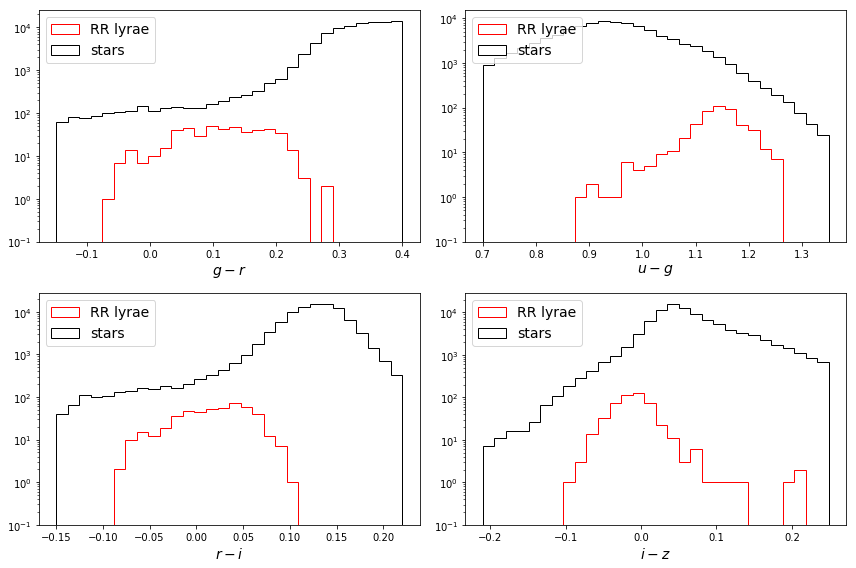

In [2]:
plt.figure(figsize=(12, 8))

for i in range(4):
    color = X[:, i]
    bins = np.linspace(np.nanmin(color), np.nanmax(color), 31)
    
    plt.subplot(221 + i)
    plt.hist(color[isRR],  bins=bins, log=True, color="r", histtype="step", label="RR lyrae")
    plt.hist(color[~isRR], bins=bins, log=True, color="k", histtype="step", label="stars")
    plt.xlabel(color_names[i]  , fontsize=14)
    plt.legend(loc="upper left", fontsize=14)
    
plt.tight_layout()
plt.show()

### Q: Why do we use colors rather than magnitudes?

[+] click to discover

[//]: # "
* Colors are independent from distance
* Colors give direct information on the shape of spectrum"

### A closer 2D look
Maybe using color-color diagrams we can easily classify RR Lyrae.

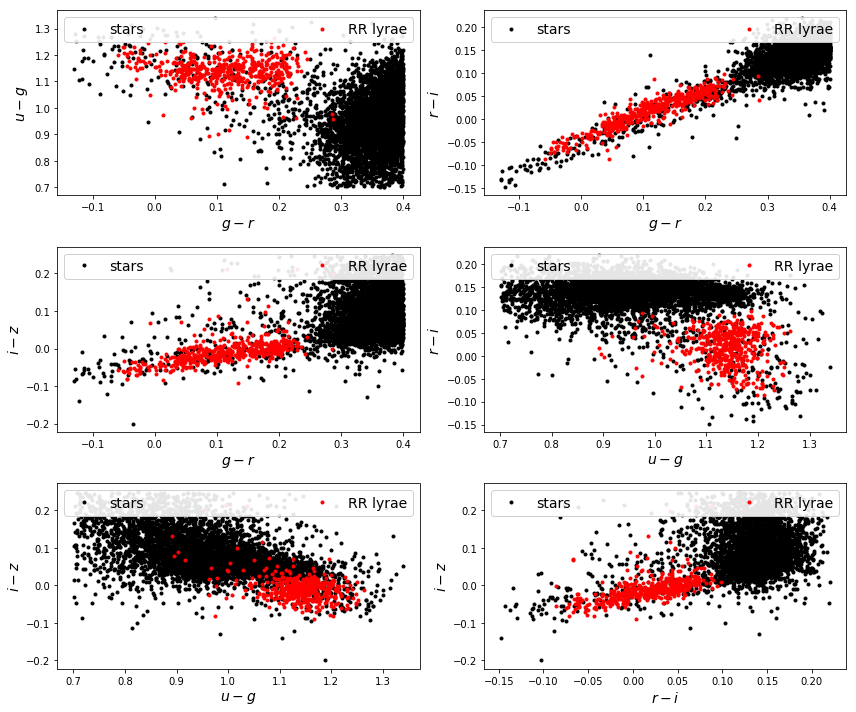

In [3]:
plt.figure(figsize=(12, 10))

k = 1
for i in range(4):
    c1 = X[:, i]
    for j in range(i + 1, 4):
        c2 = X[:, j]
        plt.subplot(320 + k)
        plt.plot(c1[noRR], c2[noRR], "k.", label="stars")
        plt.plot(c1[isRR], c2[isRR], "r.", label="RR lyrae")
        plt.xlabel(color_names[i], fontsize=14)
        plt.ylabel(color_names[j], fontsize=14)
        plt.legend(loc="upper right", framealpha=0.9, mode="expand", ncol=2, fontsize=14)
        k += 1
        
plt.tight_layout()
plt.show()

### As close as we can *see* (3D)
What if we plot three colors? Of course we cannot continue with four colors because of our 3D perception limit.

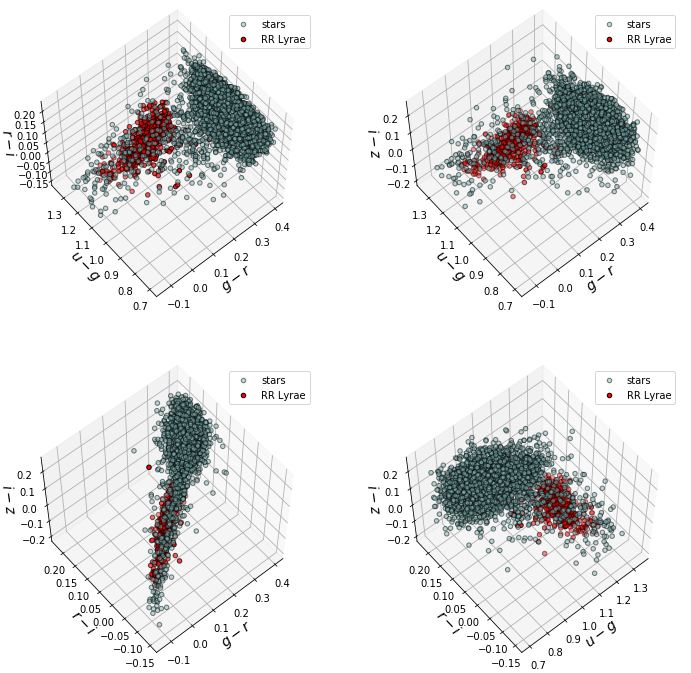

In [4]:
from mpl_toolkits.mplot3d import Axes3D

combinations = [(0, 1, 2), (0, 1, 3), (0, 2, 3), (1, 2, 3)]

fig = plt.figure(figsize=(12, 12))
for index, combination in enumerate(combinations):
    i, j, k = combination
    ax = fig.add_subplot(221 + index, projection='3d')
    ax.view_init(60, -130)  # set camera position for better visualization
    ax.scatter(X[:, i][noRR], X[:, j][noRR], X[:, k][noRR], c=[0.5,0.7,0.7], marker="o", alpha=0.5, edgecolors="k", label="stars")
    ax.scatter(X[:, i][isRR], X[:, j][isRR], X[:, k][isRR], c="r"                                 , edgecolors="k", label="RR Lyrae")
    ax.set_xlabel(color_names[i], fontsize=14)
    ax.set_ylabel(color_names[j], fontsize=14)
    ax.set_zlabel(color_names[k], fontsize=14)
    ax.legend()

plt.show()

The 3D plots do not significantly improve the *manual classification*, compared to the 2D plots. In both cases, we see a *tail* where RR Lyrae variables reside.

### Q: What we would be compromizing if we were to separate RR Lyrae by applying simple horizontal/vertical "cuts" in the 1D, 2D, or 3D color distributions?

[+] click to discover

[//]: # "Completenss versus contamination"

### 2.3. The need for a ML classifier
We can improve over the limitations of the *manual classification* by obtaining:
    
* mathematical formulation
* automation
* estimates on completeness and contamination of the classification method

## 3. $k$-Nearest Neighbors (KNN) classification

Looking at the scatter plots, we find two blobs corresponding to the different classes. Our mind uses the proximity of the points to form a "mental boundary region" (in a _discriminative classification_ fashion). In this specific case we can try to automate of the procedure, as well as the extension to arbitrary number of dimensions, by mimicking the human behaviour, i.e. by:

> attributing a given point to the class that dominates its surroundings.

The problem is then how to define the "neighborhood" of a point. The trivial solution would be to set a fixed radius. The issue then becomes its size: if too small, we **will not find neighbors** for "satellite" points at the edge of a class cluster; if too large, we **will lose resolution** in dense parts, effectively throwing away information. Therefore, ideally we would like to have a *variable bandwidth* selection threshold.

> One solution is to use a local average of the labels of the $k$ nearest neighbors:
>
> $y = \frac{1}{k} \sum￼_{x_i \in N_k(x)} y_{i}$
>
> where N_k(x) is the neighborhood around $x_i$

In this way the classification _is not_ defined based on the distance on the parameter graph, but is rather scale-independent.

Let's see a 2D example. We got two parameters and training data that are classified as being *red* or *blue*. The question is how do we classify a new (_i.e. not part of the training set_) point? The following images are taken from [here](https://importq.wordpress.com/2017/11/24/mnist-analysis-using-knn/) (we edited the the first one).

### Animated example

<table><tr>
    <td width=400>
        <img src="images/knn_neigh_initial.jpg">
        <center>Figure 3.1.a. Training data already possessing a _red_ or _blue_ label, and an arbitrary new point to be classified.</center>
    </td>    
    <td width=400>
        <img src="images/knn_neigh.gif">
        <center>Figure 3.1.b. Classification using majority votes of $k$ neighbors, fordifferent values of $k$.</center>
    </td>
    <td width=400>
        <img src="images/knn_neigh_mult.gif">
        <center>Figure 3.1.c. For a fixed $k$, the **model** can be thought as of a function of the location in the parameter space. Note that the appearing dots are _not_ part of the training set. Instead, they represent the predicted classifications **if** the new point would fall on that position.</center>
    </td>
</tr></table>

The panels *a* and *b* already suggest that the KNN classification will be affected by the choice of the **hyperparameter** $k$: we will address this issue later on.

### 3.1. Applying $k$-NN on the RR Lyrae photometric data

In [5]:
# Split the sample in a training [75% of total] and test [25% of total] subsets:
(X_train, X_test), (y_train, y_test) = split_samples(X, y, [0.75, 0.25], random_state=0)

N_tot = len(y)          # number of stars
N_st = np.sum(y == 0)   # number of non-RR Lyrae stars
N_rr = N_tot - N_st     # number of RR Lyrae
N_train = len(y_train)  # size of training sample
N_test = len(y_test)    # size of test sample
N_plot = 5000 + N_rr    # number of stars plotted (for better visualization)
Ncolors = np.arange(1, X.shape[1] + 1)    # number of available colors

print("Sample size")
print("----------------")
print("Total           | %d" % (len(X)))
print(" '-> Train      | %d" % (len(X_train)))
print("     data shape |", ((X_train.shape)))
print(" '-> Test       | %d" % (len(X_test)))
print("     data shape |", ((X_test.shape)))

Sample size
----------------
Total           | 93141
 '-> Train      | 69855
     data shape | (69855, 4)
 '-> Test       | 23286
     data shape | (23286, 4)


In [6]:
# PERFORM CLASSIFICATION FOR VARIOUS VALUES OF k

# for each 'k', store the classifier and predictions on test sample
classifiers = []
predictions = []
kvals = [1, 3, 10] # k values to be used

for k in kvals:
# trying different k hyperparameters

    classifiers.append([])
    predictions.append([])
    
    for nc in Ncolors:
    # for each k, we will use between 1 and 4 colors (1D to 4D) to classify the sources
    
        clf = KNeighborsClassifier(n_neighbors=k) # define the classifier, in this case KNN with hyperparameter k
        clf.fit(X_train[:, :nc], y_train)         # fit training set
        y_pred = clf.predict(X_test[:, :nc])      # predict class of test set

        classifiers[-1].append(clf)
        predictions[-1].append(y_pred)

# Use dedicated astroML to obtain completeness and contamination:
completeness, contamination = completeness_contamination(predictions, y_test)

print("Summary:")
print("--------")

for i,k in enumerate(kvals):
    print("k =", k)
    for nc in Ncolors:
        print("\tno. of colors = %s | " % (nc), end="")
        print("completeness: %.2f " % (completeness[i,nc-1]), end="")
        print("contamination: %.2f" % (contamination[i,nc-1]))

Summary:
--------
k = 1
	no. of colors = 1 | completeness: 0.23 contamination: 0.78
	no. of colors = 2 | completeness: 0.36 contamination: 0.53
	no. of colors = 3 | completeness: 0.47 contamination: 0.44
	no. of colors = 4 | completeness: 0.54 contamination: 0.42
k = 3
	no. of colors = 1 | completeness: 0.09 contamination: 0.73
	no. of colors = 2 | completeness: 0.35 contamination: 0.49
	no. of colors = 3 | completeness: 0.45 contamination: 0.35
	no. of colors = 4 | completeness: 0.59 contamination: 0.24
k = 10
	no. of colors = 1 | completeness: 0.01 contamination: 0.88
	no. of colors = 2 | completeness: 0.23 contamination: 0.45
	no. of colors = 3 | completeness: 0.40 contamination: 0.25
	no. of colors = 4 | completeness: 0.53 contamination: 0.24


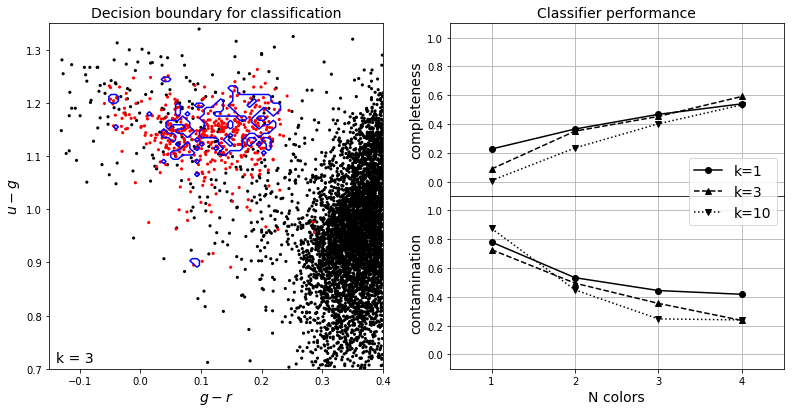

In [7]:
# COMPUTE AND PLOT DECISION BOUNDARY

import matplotlib as mpl

# classifiers
# <N_k, N_colors>

clf = classifiers[1][1]
# classifier with k=3 and the first 2 colors (g-r, and u-g)
xlim = (-0.15, 0.4) # g-r limits
ylim = (0.7, 1.35)  # u-g limits

# Creating a grid Z of predictions:
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 71), np.linspace(ylim[0], ylim[1], 81))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Creating a colormap where the RR lyrae (y label = "1") are plotted in red
cmap = mpl.colors.ListedColormap(['black', 'red'])
cmap.set_under('0.5')
cmap.set_over('0.5')

# PLOT THE RESULTS

fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

# > left plot: data and decision boundary

ax = fig.add_subplot(121)
im = ax.scatter(X[-N_plot:, 0], X[-N_plot:, 1], c=y[-N_plot:], s=10, lw=0, cmap=cmap, zorder=2)
im.set_clim(-0.5, 1.5)
ax.contour(xx, yy, Z, 1, colors='blue')
# NOTE: The contour showing the locus where a datum is classified as "RR Lyrae" is simply
#       calculated on the grid of predictions
#       To visualize the grid of predictions instead of the contour, use:
#im = ax.imshow(Z, origin='lower', aspect='auto', cmap=cmap, zorder=1, alpha=0.1, extent=xlim + ylim)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title('Decision boundary for classification', fontsize=14)
ax.set_xlabel('$g-r$', fontsize=14)
ax.set_ylabel('$u-g$', fontsize=14)
ax.text(0.02, 0.02, "k = %i" % kvals[1], transform=ax.transAxes, fontsize=14)

# > top-right plot: completeness vs Ncolors

ax = fig.add_subplot(222)
ax.plot(Ncolors, completeness[0], 'o-k' , ms=6, label='k=%i' % kvals[0])
ax.plot(Ncolors, completeness[1], '^--k', ms=6, label='k=%i' % kvals[1])
ax.plot(Ncolors, completeness[2], 'v:k' , ms=6, label='k=%i' % kvals[2])
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.set_title('Classifier performance', fontsize=14)
ax.set_ylabel('completeness', fontsize=14)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

# > bottom-right plot: contamination vs Ncolors

ax = fig.add_subplot(224)
ax.plot(Ncolors, contamination[0], 'o-k' , label='k=%i' % kvals[0])
ax.plot(Ncolors, contamination[1], '^--k', label='k=%i' % kvals[1])
ax.plot(Ncolors, contamination[2], 'v:k' , label='k=%i' % kvals[2])
ax.legend(loc='lower right', bbox_to_anchor=(1.0, 0.79), fontsize=14)
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.2))
ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
ax.set_xlabel('N colors', fontsize=14)
ax.set_ylabel('contamination', fontsize=14)
ax.set_xlim(0.5, 4.5)
ax.set_ylim(-0.1, 1.1)
ax.grid(True)

plt.show()

### Q: What does the coarsness of the decision boundary (blue contour) indicates?
[+] click to discover

[//]: # "
That indicates a potential over-fitting of the training sample, i.e. that the boudary adapts too much to this specific choice of the training set.
Therefore, when applying this trainer classifier to an other set, we might find that it does not perform well. In fact, the test tset above shows a contamination of $\sim$50 %.
"

### Q: When, in astronomical context, we would care for completeness and when about contamination?
[+] click to discover

[//]: # "
* completeness: catalogue for further cross-correlation
* contamination: sample for expensive follow-up surveys
"

### 3.2. Choosing the right $k$

### Small $k$ 
> $\large+$ only nearby points are taken into account

> $\large-$ if too small, noisy decision boundaries (see change of classification in Figure 3.1.b for small $k$'s)

### Large $k$
> $\large+$ assuming infinite sample for $k \rightarrow \infty$, the *classification error rate* is minimized

> $\large-$ **but** real-life samples are finite, so large $k$ results to loss of resolution (over-smoothing)

### Some approaches

> take $k = \sqrt{N}$

> use *cross-validation* to select optimal $k$

> if $2$ classes, go for an odd $k$ to avoid ties

Figure 3.2 (from [here](https://idc9.github.io/stor390/notes/cross_validation/cross_validation.html)) reports an example of over-smoothing.

<table>
    <tr>
        <td><img src="images/k1.jpg"   width=400></td>    
        <td><img src="images/k5.jpg"   width=400></td>
        <td><img src="images/k399.jpg" width=400></td>
    </tr>  
    <tr>
        <center>
            Figure 3.2. Variation of classification boundaries as $k$ increases to very large values.
        </center>    
    </tr>
</table>

### 3.3. Defining the neighborhood
What does "near" in "nearest neighbors" mean?
Identifying neighbors requires calculating a **distance** between points or, better said, define a **metric**. A metric might be difficult to define or might not be definable at all for the type of features we are inspecting (e.g. imagine classifying galaxies by morphology and color). Consider for example the following issues.

* One simple choice would be to adopt the common Euclidean metric. However that would not be performing properly when the parameter spans are different (e.g. one parameter has span $\left[1, 100\right]$ while the other has span $\left[0, 1\right]$). This might require **feature weighting** (normalization).
* What if all or some characteristics are not numeric but categorial? What is the metric in this case (see Hamming distance)?

For more information, consult [this document](http://www.cs.haifa.ac.il/~rita/ml_course/lectures/KNN.pdf).

### 3.4. Weighted KNN ($w$KNN)
We can mitigate the impact of choosing the appropriate $k$ by imposing that each vote on the class is weighted by the distance (or *similarity*) from the point to be classified. In this case, the classification algorithm for point $x$ becomes:

> $y = \frac{1}{k} \sum￼_{x_i \in N_k(x)} ~K(d) \times y_{i}$
>
> where $d$ is the distance and $K(d)$ is the **kernel** which converts the distance into a weight. One simple example is the inversion kernel $K(d) = \frac{1}{d}$

For an extensive treatment, consult [Hechenbichler (2004)](https://epub.ub.uni-muenchen.de/1769/1/paper_399.pdf).

### 3.5. Final remarks on KNN

### Pros
* No need to assume distribution (_discriminative classifier_)
* Simple and intuitive
* Robust for large samples

### Cons
* Hard to select $k$
* Computationally expensive: $O(nkd)$, where $n$ is the size of training sets, and $d$ is the dimension of each training set (but can be optimised)
* Good accuracy requires large samples unifromly covering the parameter space

## 4. Support Vector Machine (SVM)

Support vector machine (SVM) is a way of choosing a decision boundary between different classes.

The classification boundary is provided by the hyperplane maximizing the distance between the hyperplane itself and the closest point from either class. This distance is called *margin*. Points on the margins are called *support vectors*.

<table><tr>
    <td width=400>
        <img src="images/SVM_1.png">
        <center>Figure 4.1.a. Hyperplane (dashed line) separating two classes (_red_ and _green_).</center>
    </td>    
    <td width=400>
        <img src="images/SVM_2.png">
        <center>Figure 4.1.b. The closest points to the hyperplane from each class constitute the "tip" of the *support vectors*.</center>
    </td>
</tr></table>

Figure 4.1.a shows two different classes (e.g. young and old stars) distributing in a scatter plot according to variable $x_1$ (e.g. radius) and $x_2$ (e.g. temperature). Figure 4.1.b explains the origin of the name "support vectors": the closest points _support_ the hyperplanes (solid lines) equally distant from the decision hyperplane (dashed line).

Infinite possible boundaries can separate the two classes. SVM algorithms find the one that maximizes the distance between the supported hyperplanes.

### 4.1. Hyperplanes and decision boundary

The supported hyperplanes (solid-lines in Figure 4.1.a can be defined as:

> **w**$\cdot$**x** + b = +1
>
> **w**$\cdot$**x** + b = -1

where **x** is the coordinate on the (x1, x2) plane, **w** is a 2$\times$1 matrix and **b** a scalar. It turns out that these hyperplanes are separated by a distance 2 / ||w||. Finding the ideal classification boundary, i.e. the one maximizing the distance, is therefore a problem of minimizing the norm ||w||. This is what SVM algorithms do.

For a complete mathematical formulation, consult [this document by Berwick, R.]( http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf).

### 4.2. Separatable classes (or not)

We cannot always assume that 2 classes are separble without "contamination". That is why SVM algorithms include **slack variables**, a tunable parameter which penalizes misclassifications.


### 4.3. Multiple classes

The SVM method can be applied for multiple classes as well (Figure 4.3).

<img src="images/svm_many_classes.png" width=400>
<center>
    Figure 4.3: SVM applied to 3 different classes.
</center>

### 4.4. Multiple dimensions

If our sample of stars is characterized by three parameters (X, Y, Z), e.g. radius, temperature and mass, then the scatter plot has 3 dimensions (Figure 4.3). The boundary between the classes in the 3-D plot is a plane. Because of the fact that the method can be extrapolated at N-dimensions, the boundary is a *hyperplane*.

<img src="images/svm_3d.png" width=400>
<center>
    Figure 4.4: Support vector machine applied for 3-D features and three classes.
</center>

### 4.5. Applying linear SVM to the RR Lyrae photometric data

We will use SVM to our RR Lyrae example to separate objects with a linear decision boundary.
In $\S$4.6 and $\S$4.7 we will see an extension of SVM adopting non-linear boundaries.

In [8]:
# In this block, we define a function that applies SVM on our data.
# If the boolean argument is set to `True`, it applies the linear SVM (this section)
# otherwise it uses Gaussian Radial Basis function kernel (RBF; Section 4.7).

def apply_SVM(linear):
    if linear:
        kernel_to_use = "linear"
        gamma_to_use = "auto"
    else:
        kernel_to_use = "rbf"
        gamma_to_use = 20.0

    def compute_SVM(Ncolors):
        classifiers = []
        predictions = []
        
        for nc in Ncolors:
            print("    Computing for", nc, "color(s)...")
            # perform support vector classification
            clf = SVC(kernel=kernel_to_use, gamma=gamma_to_use, class_weight='balanced')
            clf.fit(X_train[:, :nc], y_train)
            y_pred = clf.predict(X_test[:, :nc])

            classifiers.append(clf)
            predictions.append(y_pred)

        return classifiers, predictions

    print("Performing SVM classification...")

    classifiers, predictions = compute_SVM(Ncolors)

    completeness, contamination = completeness_contamination(predictions, y_test)

    print("completeness",  completeness)
    print("contamination", contamination)

    # COMPUTE THE DECISION BOUNDARY
    
    """
    NOTE: The sklearn SVM routine does _not_ return the coefficients of the
          decision boundary.
          For example, for a 2D case where the decision boundary is a line
          of the type:
    
             y = a*x + b
    
          one would expect to obtain "a" and "b" (where b == intercept).
          Instead, the w matrix is returned (see Section 4.1).
          In the 2D case, for a linear model, the conversion is trivial
          (see the code below for a linear case).
          
          For a more generic case of representing a curved boundary in N
          dimensions, it is more convenient to generate a grid ("Z") of
          predictions covering the whole parameter space (essentially a map
          of the classes), and then plot the contour around a class
          (see the code below for a non-linear case).
          
          Alternatively, one can use the sklearn built-in function to
          draw the decision function:

              https://scikit-learn.org/stable/auto_examples/svm/plot_separating_hyperplane.html
    """
    
    clf = classifiers[1]
    # loading classifier for 2 colors

    if linear:
        # > Extracting slope and intercept of boundary line:
        w = clf.coef_[0]
        a = -w[0] / w[1]
        yy = np.linspace(-0.1, 0.4)
        xx = a * yy - clf.intercept_[0] / w[1]
    else:
        # > Creating a grid of predictions:
        xlim = (0.7, 1.35)
        ylim = (-0.15, 0.4)
        xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 101), np.linspace(ylim[0], ylim[1], 101))
        Z = clf.predict(np.c_[yy.ravel(), xx.ravel()])
        Z = Z.reshape(xx.shape)
        # Smooth the boundary:
        from scipy.ndimage import gaussian_filter
        Z = gaussian_filter(Z, 2)

    # PLOT THE RESULTS

    fig = plt.figure(figsize=(12, 6))
    fig.subplots_adjust(bottom=0.15, top=0.95, hspace=0.0, left=0.1, right=0.95, wspace=0.2)

    # left plot: data and decision boundary
    ax = fig.add_subplot(121)
    im = ax.scatter(X[-N_plot:, 1], X[-N_plot:, 0], c=y[-N_plot:], s=4, lw=0, cmap=plt.cm.binary, zorder=2)
    if linear:
        ax.plot(xx, yy, '-k')
    else:
        ax.contour(xx, yy, Z, [0.5], colors='k')

    
    im.set_clim(-0.5, 1)
    ax.set_xlim(0.7, 1.35)
    ax.set_ylim(-0.15, 0.4)
    ax.set_xlabel('$u-g$', fontsize=14)
    ax.set_ylabel('$g-r$', fontsize=14)

    # plot completeness vs Ncolors
    ax = fig.add_subplot(222)
    ax.plot(Ncolors, completeness, 'o-k', ms=6)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_ylabel('completeness', fontsize=14)
    ax.set_xlim(0.7, 4.5)
    ax.set_ylim(0.9, 1.04)
    ax.grid(True)

    # plot contamination vs Ncolors
    ax = fig.add_subplot(224)
    ax.plot(Ncolors, contamination, 'o-k', ms=6)
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))
    ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%i'))
    ax.set_xlabel('N colors',      fontsize=14)
    ax.set_ylabel('contamination', fontsize=14)
    ax.set_xlim(0.7, 4.5)
    ax.set_ylim(0.8, 1.04)
    ax.grid(True)

    plt.show()

Performing SVM classification...
    Computing for 1 color(s)...
    Computing for 2 color(s)...
    Computing for 3 color(s)...
    Computing for 4 color(s)...
completeness [0.99270073 1.         1.         1.        ]
contamination [0.90014684 0.85347594 0.85347594 0.85471898]


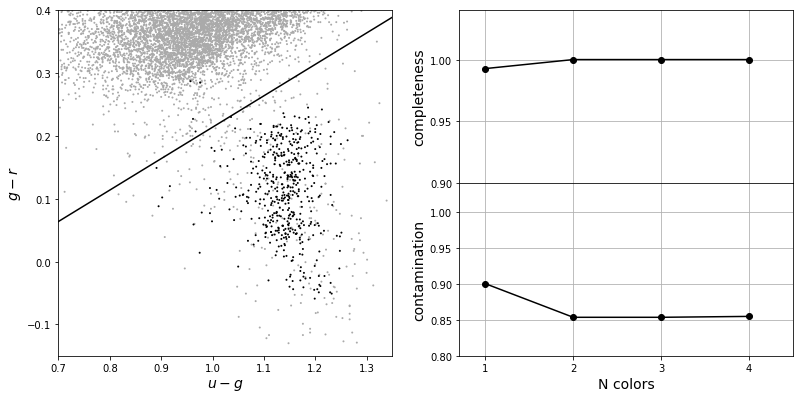

In [9]:
apply_SVM(linear=True)

Not the best result in terms of contamination! Let's try something more sophisticated ...

### 4.6. Non-linear boundaries

Sometimes, linear boundaries may not be optimal and a non-linear SVM should be used instead. The left panel of Figure 4.6 shows an 2D scatter plot of two different classes (e.g. red and green stars with different radii and temperatures) which cannot be linearly separated.

In order to find non-linear boundaries we can tackle the problem in an higher dimensional space. We use a process called **kernelization**, which consists in using a kernel function to attribute to our data a value in the additional dimension. Then, we draw the decision hyperplane into this higher dimensional space.

The central panel of Figure 4.6 shows that once the 2D data are mapped to a 3D space by attributing a $z$ value through a Gaussian-like function, the classes are easily separable by a 3D hyperplane. Projecting back the plane in 2D, we obtain the non-linear boundary (Figure 4.6, rght panel).

<img src="images/kernel.png" width=800>
<center>
    Figure 4.6. When no linear boundaries can be used the SVM method can be applied by using kernel.
</center>

### Choosing the kernel function

Useful kernel functions shall satisfy specific conditions (see [7]), so that in practice only a few are used. In the example of Figure 4.6, the Gaussian Radial Basis Function is used:

> $K(x,y) = e^{-\gamma(x-y)^2}$

where $\gamma$ is a hyperparameter which shall be learned via cross-validation (in our example we use an arbitrary value).

### 4.7. Applying kernelized SVM to the RR Lyrae photometric data

Performing SVM classification...
    Computing for 1 color(s)...
    Computing for 2 color(s)...
    Computing for 3 color(s)...
    Computing for 4 color(s)...
completeness [1. 1. 1. 1.]
contamination [0.90108303 0.83901293 0.83573141 0.81561238]


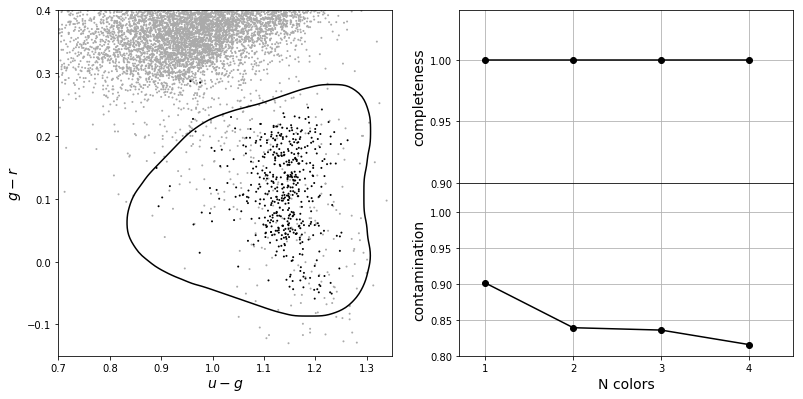

In [10]:
apply_SVM(linear=False)

We improved our results, but the contamination is still high.
We will probably have to accept this limitation because RR Lyrae simply occupy a locus of the colors diagrams which is also populated by other stellar types.

### 4.8. Misclassifications

Figure 4.3 shows that the blue points class is contaminated by some green 
points (*misclassified* points). Likewise, the green points class is contaminated by blue points. This contamination makes it difficult to define the boundary between the two classes.

Keep in mind that SVM finds the hyperplane that maximizes the margin and indirectly minimizes the misclassifications. However SVM is not designed to minimize the contamination _per se_.


### 4.9. Final remarks on SVM

### Pros
* Good at dealing with high dimensional data
* Works well on small data sets

### Cons
* Picking the right kernel and parameters can be computationally intensive
* It suffers from contamination


For further information on SVM, consult [this link](http://www.saedsayad.com/support_vector_machine.htm).

## 5. Random Forests (RFs)

### 5.1. Decision Tree

A **Decision Tree** (**DT**) is simply a top-to-bottom tree-like structure where each node corresponds to a question (or a set of features more generally) that distinguishes objects to two groups, left and right from the node. A decision tree presents the drawback of learning extremely well the training set. That means that DTs overfit the data and they cannot predict very accurately new data.

### 5.2. Random Forests

**Random Forests** (**RFs**) or Random Decision Trees ([Breiman (2001), Machine Learning, 45, 5](https://doi.org/10.1023/A:1010933404324)) is a generalization of the DTs, as it utilises a multitude of decision trees. When RFs are used as a classification (/regression) method, for each input datum the final output is the class (/value) given by the mode of the classes (/mean prediction) of the individual trees.

<img src="images/RandomForests.jpg" width=600>
<center>
    Figure 5.1. Schematic description of the Random Forests classifier.
</center>


RFs create a large number of DTs through random selection of a subset of the training set as well as a random selection of features. This randomness reduces the correlation between the different DTs. Since the DTs have different conditions in their nodes and different overall structures, this diversity yield overall robust predictions. 

Once the RFs has been trained, a [unlabeled] datum to be classified is fed into all DTs of the forest. According to its properties and the nodes in each DT, it follows a specific path which leads to a given class. The final output of the RFs (the prediction) is an aggregation of all DTs by means of a majority vote.

#### Read also: 
[Reis, Baron, & Shahaf (2019), AJ, 157, 16](https://ui.adsabs.harvard.edu/abs/2019ascl.soft03009R/abstract) provide an excellent description of RFs (for a two-class problem) and present a  robabilistic RFs method which takes into account the uncertainties on the data and their labels.

### 5.3. Using RFs to classify massive stars

In this example we are using a set of photometric measurements (from optical to mid-IR bands) for a sample of massive evolved stars in the Large Magellanic Cloud. We are aiming at building a classifier which can distinguish between Blue, Yellow, and Red supergiants (BSG, YSG, RSG, respectively). 


_NOTE: The sample is based on the works by [Bonanos et al. (2009) AJ, 138, 1003](https://ui.adsabs.harvard.edu/abs/2009AJ....138.1003B/abstract), [Neugent et al. (2012), ApJ, 749, 177](https://ui.adsabs.harvard.edu/abs/2012ApJ...749..177N/abstract), and [Davies, Crowther & Beasor (2018), MNRAS, 478, 313](https://ui.adsabs.harvard.edu/abs/2018MNRAS.478.3138D/abstract)._

### Loading data

In [11]:
###############
# Load the data
dfile = "data/lmc_phot_data.csv"

missing_value = -999.0

# Assinging automatically the type for each column
with open(dfile) as f:
    cols = len( f.readline().split(',') ) 

dt_dtype = (int), 
dt_dtype += ('S3'), 
for i in range(cols-2): #cols:
    dt_dtype +=   (float),
#print(dt_dtype)


data = np.genfromtxt(dfile, unpack=True, comments='#', names=True, 
                    autostrip='Yes', dtype=dt_dtype, delimiter=',',
                    )
#print(data['SpectralType'])

######################################
# Group the different spectral classes 
#found and keep their indeces
from collections import defaultdict

spectral_types = defaultdict(list)

for i in range(0,len(data['SpectralType'])): 
    spectral_types[data['SpectralType'][i].decode('UTF-8')].append(i)

#print(spectral_types)
unique_spt = sorted(set(spectral_types.keys()))

print("> SUMMARY of loaded data:")
print("=========================")
for sptype in unique_spt:
    number = len(spectral_types[sptype])
    print("{:-<6s}--> {:>3} stars".format(sptype, number))

> SUMMARY of loaded data:
BSG-----> 136 stars
RSG-----> 299 stars
YSG-----> 164 stars


### Examining coverage of photometric data

In [12]:
from astropy.table import Table, Column

bands = [n for n in data.dtype.names[2:]]
print("Available photometry for: {}".format(", ".join( [bb for bb in bands])))

# Constructing the table for the statistics 
phot_data_col_names = ['Class', 'All'] + [bb for bb in bands]
phot_data_per = Table( names = phot_data_col_names, dtype = ['S3']+['i4']+['f2']*(len(bands)))

for sptype in unique_spt:
    indcs = spectral_types[sptype]
    starsWbands = defaultdict(list)
    for star in indcs:
        for bnd in bands:
            mag = data[star][bnd]
            if mag!=missing_value:
                starsWbands[bnd].append(star)    
    row_data_per = [sptype, len(indcs)] + [(len(starsWbands[bb])/len(indcs))*100 for bb in bands]
    phot_data_per.add_row ( row_data_per )
    
print("\nNumber of stars per band (in %)\n")
phot_data_per    

Available photometry for: U, B, V, I, J, H, K, 36um, 45um, 58um, 80um, 24um

Number of stars per band (in %)



Class,All,U,B,V,I,J,H,K,36um,45um,58um,80um,24um
bytes3,int32,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16,float16
BSG,136,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,2.205
RSG,299,88.3,99.3,99.3,96.0,100.0,99.7,100.0,98.7,98.3,98.3,99.0,99.0
YSG,164,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,99.4


### Bands and their effective wavelengths

For each band, the effective wavelength and a zero point value (in Jy) is derived from:
<br>
http://svo2.cab.inta-csic.es/theory/fps/ 

_NOTE: using the Johnson values for UBVRI_

In [13]:
bands2wavs = {'U':3570.6, 'B':4378.1, 'V':5466.1, 'R':6695.6, 'I':7978.8,
              'J':12350.0, 'H':16620.0, 'K':21590.0,
              '36um':35075.1, '45um':44365.8, '58um':56281.0, '80um':75891.6, '24um':236800.0 }

### Data processing for RFs

Try to play and select a different set of bands to explore how the performance of the classifier changes.

In [14]:
# Select the bands you want to use here:
bands_selected = ['B', 'V', 'J', 'K', '36um', '58um'] 
#bands_selected = ['U', 'B', 'V', 'H', 'K', '36um', '58um']

wavs_selected = [ bands2wavs[b] for b in bands_selected ]
# taking the average value of the two consequtive bands
wavs_selected_diff = [ (wavs_selected[w+1]+wavs_selected[w])/2 for w in range(0, len(wavs_selected)-1,1) ]

ml_data_mags = []   # working with magnitudes directly
ml_data_diff = []   # taking magnitude differences (next-previous) - color indices
ml_labels    = []
ml_objects   = []

print("# stars with mags in: {}".format(",".join([bb for bb in bands_selected]) )  )
print("=========================")
print("Type    initial    final ")
print("-------------------------")
init = 0 # initial total number of stars (added after each iteration)
for sptype in unique_spt:
    indcs = spectral_types[sptype]
    kept = []
    init += len(indcs)
    for star in indcs:
        mag_list = list(data[star][bands_selected])
        if missing_value in mag_list:
            #print('REJECTING!!! <',data[star])
            continue
        else:
                       
            # Not the optimal solution to make a list since it is an array.
            # But the structured arrays chnged after v1.14 and 
            # it gets a bit complicated - see the following link:            
            # https://stackoverflow.com/questions/50028309/convert-a-slice-of-a-structured-array-to-regular-numpy-array-in-numpy-1-14?rq=1
            mag = [ i for i in mag_list ] #data[star][bands_selected] ]
            
            # creating the difference between the mags
            dif = [mag[i+1]-mag[i] for i in range(len(mag)-1)]
            
            ml_data_diff.append(dif)
            ml_data_mags.append(mag)
            ml_labels.append(sptype)
            ml_objects.append(data[star]['Star_ID'])
            kept.append(sptype)           

    print('{:<4}  {:>9} {:>8}'.format(sptype, len(indcs), len(kept)))
print("-------------------------")
print("TOTAL:  {:>7}  {:>7}".format(init, len(ml_data_mags)))   

ml_data_mags = np.asarray(ml_data_mags)
ml_data_diff = np.asarray(ml_data_diff)
ml_objects   = np.asarray(ml_objects)



# stars with mags in: B,V,J,K,36um,58um
Type    initial    final 
-------------------------
BSG         136      136
RSG         299      292
YSG         164      164
-------------------------
TOTAL:      599      592


### Plotting data per class


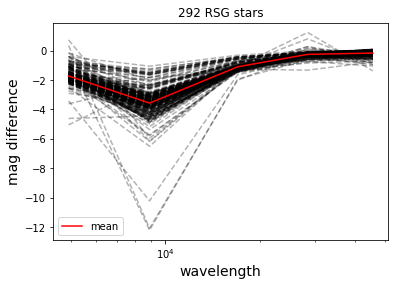

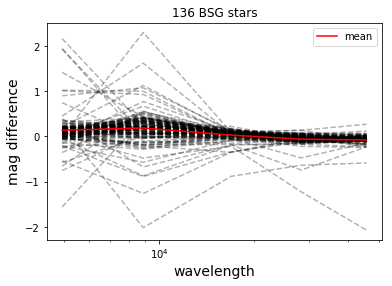

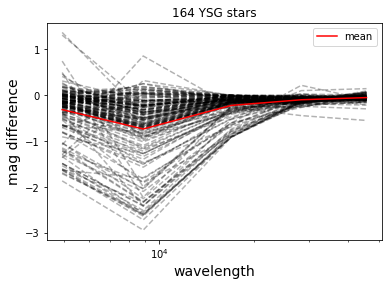

In [15]:
%matplotlib inline

import matplotlib.pyplot as plt

# Converting type_ids to float numbers:
unique_types = list(set(ml_labels))  # list of unique grouped spectral types 
ml_labels_int = []
for i in ml_labels:
    ml_labels_int.append(unique_types.index(i))
ml_labels_int = np.asarray(ml_labels_int)

# Collecting all indeces for a specific class and 
# plotting the raw (gray) and mean (red) data:
for i in range(len(unique_types)):
    ind2use = np.where( ml_labels_int==i )
    data2use = ml_data_diff[ind2use]       # mag differences
    data2use_mean = [ np.mean(data2use[:,k]) for k in range(len(data2use[0])) ]
    for dd in data2use:
        plt.semilogx(wavs_selected_diff, dd, '--k', alpha=0.3)             # mag diff vs wav
        plt.title('{} {} stars'.format(len(ind2use[0]), unique_types[i]))
    plt.semilogx(wavs_selected_diff , data2use_mean, '-r', label='mean')   # mag diff vs wav  

    plt.legend()
    plt.ylabel('mag difference', fontsize=14)
    plt.xlabel('wavelength',     fontsize=14)
    plt.show()

### Shuffling and splitting samples

Our sources are actually sorted by their spectral type. Therefore, we need to randomize our input before selecting our training and validation samples.

In [16]:
shuffled_indcs = np.arange(len(ml_labels_int))
np.random.shuffle(shuffled_indcs)

ml_data_diff_sfld = ml_data_diff[shuffled_indcs]
ml_labels_int_sfld = ml_labels_int[shuffled_indcs]
ml_objects_sfld = ml_objects[shuffled_indcs]

In [17]:
# Splitting in training, validation, and test samples:
n_samples = len(ml_labels_int_sfld)

data_train = ml_data_diff_sfld[:8 * n_samples // 10] # i.e. 80% training
labels_train = ml_labels_int_sfld[:8 * n_samples // 10]
objects_train = ml_objects_sfld[:8 * n_samples // 10] 

data_valid = ml_data_diff_sfld[8 * n_samples // 10:] # i.e. 20% validation 
labels_valid = ml_labels_int_sfld[8 * n_samples // 10:]
objects_valid = ml_objects_sfld[8 * n_samples // 10:]


print("Sample Summary")
print("________________________")
print("Total sample     | %5s" % n_samples)
print("-----------------|------")
print(" '-> Training    | %5s" % len(data_train))
print("-----------------|------")
print(" '-> Validation  | %5s" % len(data_valid))

print('')
print('Compare these values with the accuracy of each classifier')
print('If accuracies are similar to the demographics, the classifier is only mirroring the data')

Sample Summary
________________________
Total sample     |   592
-----------------|------
 '-> Training    |   473
-----------------|------
 '-> Validation  |   119

Compare these values with the accuracy of each classifier
If accuracies are similar to the demographics, the classifier is only mirroring the data


### Applying the RFs 

In [18]:
from sklearn import datasets, utils, metrics
from sklearn.ensemble import RandomForestClassifier
        
from matplotlib import cm

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()        

Classification report for RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False):
             precision    recall  f1-score   support

          0       0.95      1.00      0.98        60
          1       0.84      0.88      0.86        24
          2       0.90      0.80      0.85        35

avg / total       0.92      0.92      0.91       119


Confusion matrix:
[[60  0  0]
 [ 0 21  3]
 [ 3  4 28]]


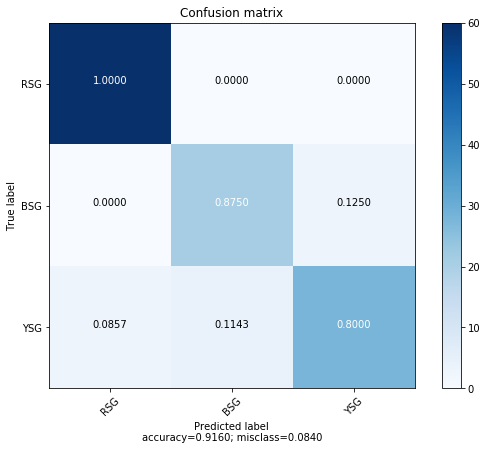

In [19]:
# Classifier
model_RF = RandomForestClassifier()
model_RF.fit(data_train, labels_train)

# Comparisong with prediction
predicted = model_RF.predict(data_valid)

print("Classification report for %s:\n%s\n"
      % (model_RF, metrics.classification_report(labels_valid, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(labels_valid, predicted))

cm = metrics.confusion_matrix(labels_valid, predicted)
plot_confusion_matrix(cm, unique_types, title='Confusion matrix', cmap='Blues', normalize=True)

The above confusion matrix shows us how well the algorith performs. It compares the true labels to the ones predicted, and reports the misidentifications. The corresponding numbers refer to the percentage of sources that have been correctly classified (the closer to unity, the better the prediction).

### Q:  Why the algorithm performance changes when re-running it with the same setup?

[+] click to discover

[//]: # "
The small size of the sample introduces a certain degree of randomness when splitting it into train and validation sub-sets.
"

### Q:  What is the difference on the accuracy of the algorithm if we use the magnitudes directly instead of their differences ? 

### 5.4. Final remarks on Random Forests

In machine learning most of the effort is actually spent on the **sample** selection and, most importantly, on the selection of the **features** used for the classification (feature engineering).

RFs partially overcome the latter problem by training each DT on a different sub-set of features, hence training the algorithm to recognize the features which mostly differentiate the objects.